In [1]:
import os, sys
import numpy as np
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time
import scipy
import sys

In [2]:
%matplotlib inline

def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    
def compute_spectrogram(path, start=None, end=None, Fs=11025, N=1024, H=512, bin_max=512, frame_max=None):
    x, Fs = librosa.load(path, sr=Fs)
    x = librosa.to_mono(x)
    if start is not None or end is not None:
        start_time = start * Fs
        end_time = end * Fs
        x = x[start_time:end_time]
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[1]
    Y = np.abs(X[:bin_max, :])
    return Y

def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode="constant")
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

def create_group(Cmap, dist_to_tz=30, tz_w=201, tz_h=171):
    """
    Parameters:
        Cmap: constellation map
        dist_to_tz: distance from each anchor point to left size of target zone
        tz_w: width of target zone
        tz_h: height of target zone
    Returns:
        a dict of {anchor point: [list of points in target zone]}
    """

    # get all peaks, each peak is a pair (time, frequency)
    points = np.argwhere(Cmap.T == True)
    # sort by time then frequency
    points = points[np.lexsort((points[:, 1], points[:, 0]))]

    groups = []
    
    hh = tz_h // 2
    
    for i in range(len(points)):
        anchor = points[i]
        
        x_lo_bo = anchor[0] + dist_to_tz
        x_hi_bo = anchor[0] + dist_to_tz + tz_w
        y_lo_bo = anchor[1] - hh
        y_hi_bo = anchor[1] + hh

        # print(f"{x_lo_bo}, {x_hi_bo}, {y_lo_bo}, {y_hi_bo}")
        g = []
        for j in range(i+1, len(points)):
            # print(f"j: {j}")
            target = points[j]
            # print(target)
            if (x_lo_bo <= target[0] <= x_hi_bo) and (y_lo_bo <= target[1] <= y_hi_bo):
                g.append(target)

        g.insert(0, anchor)
        groups.append(g)

    return groups

def create_hashes(Cmap, dist_to_tz=30, tz_w=201, tz_h=171):
    groups = create_group(Cmap, dist_to_tz, tz_w, tz_h)
    hashes = []
    
    for group in groups:
        if len(group) == 1:
            continue  # skip if there's only an anchor and no target zone points
    
        # masked anchor point frequency (9 bits)
        x1 = group[0][1] & ((1 << 9) - 1)
        
        for tz_point in group[1:]:
            # masked target zone frequency (9 bits)
            x2 = tz_point[1] & ((1 << 9) - 1)
            # delta time between anchor and target (14 bits)
            delta_time = tz_point[0] - group[0][0]
            x3 = delta_time & ((1 << 14) - 1)

            # combine into a single 32-bit hash
            combined_hash = (x1 << (9 + 14)) | (x2 << 14) | x3
            hashes.append((int(combined_hash), delta_time))

    return hashes

In [4]:
# do not change this
Fs = 11025
dist_freq = 35  # kappa: neighborhood in frequency direction
dist_time = 10  # tau: neighborhood in time direction
thresh = 0.01
N = 1024
H = 256

path = r"C:\Users\PC MY TU\Desktop\music-search\song_db\songs\1.mp3"
start_at = 30 # second at which the query starts
end_at = 45 # second at which the query ends

start = time.time()
Y = compute_spectrogram(path, Fs=Fs, N=N, H=H)
end = time.time()
print(f"time to compute spectrogram (original): {end - start:.2f}")
start = time.time()
Y_query = compute_spectrogram(path, Fs=Fs, N=N, H=H)
end = time.time()
print(f"time to compute spectrogram (query): {end - start:.2f}")

start = time.time()
Cmap = compute_constellation_map(Y, dist_freq, dist_time, thresh=thresh)
end = time.time()
print(f"\ntime to compute constellation map (original): {end - start:.2f}")
start = time.time()
Cmap_query = compute_constellation_map(Y_query, dist_freq, dist_time, thresh=thresh)
end = time.time()
print(f"time to compute constellation map (query): {end - start:.2f}")
print(f"\ntotal peaks (original): {Cmap.sum()}\ntotal peaks (query): {Cmap_query.sum()}")

# title = r'Constellation map using $\kappa=%d$, $\tau=%d$' % (dist_freq, dist_time)
# fig, ax, im = plot_constellation_map(Cmap, np.log(1 + 1 * Y), color='r', s=30, title=title)

dist_to_tz = 20
tz_w = 251
tz_h = 171

hashes = create_hashes(Cmap, dist_to_tz, tz_w, tz_h)
hashes_query = create_hashes(Cmap_query, dist_to_tz, tz_w, tz_h)
print(len(hashes))

time to compute spectrogram (original): 0.76
time to compute spectrogram (query): 0.72

time to compute constellation map (original): 0.22
time to compute constellation map (query): 0.20

total peaks (original): 2662
total peaks (query): 2662
52842


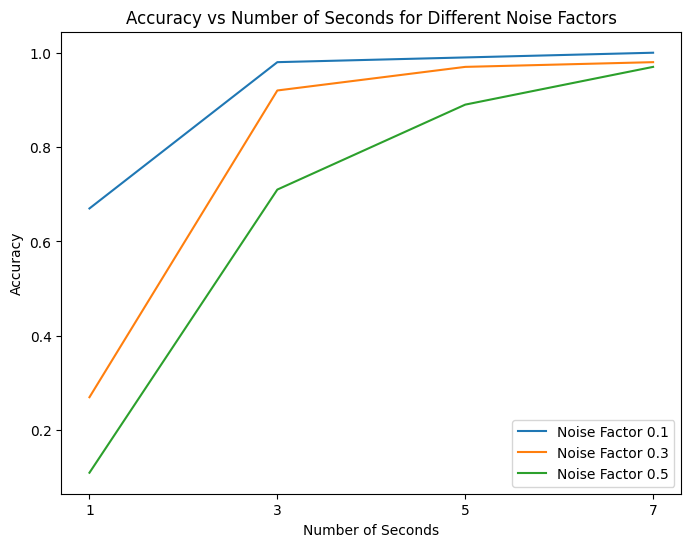

In [7]:
import matplotlib.pyplot as plt

seconds = [7, 5, 3, 1]
noise_factors = [0.1, 0.3, 0.5]
accuracies = {
    0.1: [1, 0.99, 0.98, 0.67],
    0.3: [0.98, 0.97, 0.92, 0.27],
    0.5: [0.95, 0.89, 0.71, 0.11],
}

plt.figure(figsize=(8, 6))

for factor, acc in accuracies.items():
    plt.plot(seconds, acc, label=f'Noise Factor {factor}')

plt.xlabel('Number of Seconds')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Seconds for Different Noise Factors')

plt.xticks(seconds)
plt.legend()

plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')

plt.show()